# Exploring diffusion models

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import math
import sklearn.datasets


# Reconstructing DDPM on Simulated Data
Through this project, I aim to reimplement the methodology from "Denoising Diffusion Probabilistic Models" (DDPM). This involves simulating data generation from a known distribution and then demonstrating the reversal process using both analytical and estimated score functions.

The original paper can be found here: https://arxiv.org/pdf/2006.11239

## Creating Samples from a Gaussian Mixture Model
We begin by setting our hyperparameters for the Gaussian Mixture Model (GMM).

In [2]:
n_components = 3
weights = np.array([.3, .3, .4])
means = np.array([
      [0, 0],
      [6, 0],
      [2, 6]
    ])
covariances = np.array([
    [[1.0, -1], [-1, 2]],
    [[3.0, .75], [.75, 1.0]],
    [[2, 1], [1, 1]]
])


We now initialize our GMM with the defined parameters.

In [3]:
gmm = GaussianMixture(n_components=n_components, covariance_type='full')
gmm.weights_ = weights
gmm.means_ = means
gmm.covariances_ = covariances

Define the number of samples to generate.

In [4]:
num_samples = 10000

We now generate samples from the initialized GMM and plot the data points to visualize the distribution.

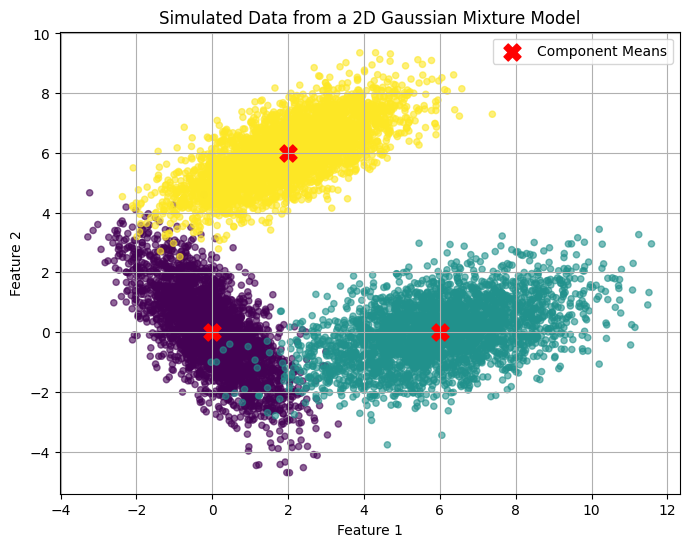

In [5]:
X_simulated, y_new = gmm.sample(num_samples)

plt.figure(figsize=(8, 6))

plt.scatter(
    X_simulated[:, 0],  # (X-coordinates)
    X_simulated[:, 1],  # (Y-coordinates)
    c=y_new,
    s=20,
    cmap='viridis',
    alpha=0.6
)

plt.scatter(
    gmm.means_[:, 0],
    gmm.means_[:, 1],
    marker='X',
    s=150,
    color='red',
    label='Component Means'
)

plt.title('Simulated Data from a 2D Gaussian Mixture Model')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

##**Adding noise through iterations**

###**To naively add noise to our data, we have the following algorithm to add noise:**

Suppose $g(t)$ is the diffusion coefficient and $z_t \sim \mathcal{N} (0, I)$ from some time step $t$.

Then, we can model the noise adding process as
$$x_{t + 1} = x_t + g(t)z_t$$
meaning that from each time step from $t = 0$ to $t = T$, we are adding gaussian noise to the sample in the previous timestep.

However, this naive approach of adding noise results in exploding variance at time step $T$.
<br>
<br>
###**To address the problem of exploding gradients, we now look at the method that was used in the DDPM paper.**

Suppose $\beta_t$ is the diffusion coefficient and $z_t \sim \mathcal{N} (0, I)$ from some time step $t$.

Then, our we add noise by:
$$x_{t + 1} = \sqrt{1 - \beta_t} x_t + \sqrt{\beta_t}z_t$$

and thus, addressing our issue of exploding variance since

$$(\sqrt{1 - \beta_t})^2 + (\sqrt{\beta_t})^2 = (1 - \beta_t) + \beta_t = 1$$

As a final note on the computation, let $\alpha_t = 1 - \beta_t$. Then,
$$
\begin{align}
x_{t + 1} &= \sqrt{\alpha_t} x_t + \sqrt{1 - \alpha_t}z_t \\
\implies x_{t + 2} &= \sqrt{\alpha_{t + 1}}(\sqrt{\alpha_t} x_t + \sqrt{1 - \alpha_t}z_t) + \sqrt{1 - \alpha_{t + 1}}z_{t + 1} \\
&= \sqrt{\alpha_{t + 1}\alpha_t} x_t + \sqrt{\alpha_{t+1}(1 - \alpha_t)}z_t + \sqrt{1 - \alpha_{t + 1}}z_{t + 1}
\end{align}
$$

Therefore, when looking at the mean of $x_{t + 2}$, we see that the mean is multiplied by a factor of $\sqrt{\alpha_{t + 1} }$ from the mean of $x_{t + 1}$, which is multiplied by a factor $\sqrt{\alpha_t}$ from the mean of $x_t$, etc... ($z_t$ doesn't affect the mean since it assumes standard normal distribution)

Furthermore, when looking at the variance of $x_{t + 2}$, we see that have sources of variance from $x_t, z_t, z_{t+1}$ Thus,
$$
\begin{align}
\sigma^{2}_{t + 2} &= (\sqrt{\alpha_{t + 1}\alpha_t})^2 + (\sqrt{\alpha_{t+1}(1 - \alpha_t)})^2 + (\sqrt{1 - \alpha_{t + 1}})^2 \\
&= (\alpha_{t + 1}\alpha_t) + [ \alpha_{t+1}(1 - \alpha_t) + (1 - \alpha_{t + 1}) ] \\
&= (\alpha_{t + 1}\alpha_t) + [ \alpha_{t+1} - \alpha_{t+1} \alpha_t + (1 - \alpha_{t + 1}) ]\\
&= (\alpha_{t + 1}\alpha_t) + 1 - \alpha_{t+1} \alpha_t \\
\implies \sigma_{t+2} &= \sqrt{(\alpha_{t + 1}\alpha_t) + 1 - \alpha_{t+1} \alpha_t}
\end{align}
$$

With this in mind, let $\bar{\alpha_t} = \alpha_1 \times ... \times \alpha_{t - 1}$. Then,
$$x_{t} = \sqrt{1 - \beta_{t-1}} x_{t-1} + \sqrt{\beta_{t-1}}z_{t-1}
\iff x_{t} = \sqrt{ \bar{\alpha_{t} } } x_0 + \sqrt{1 - \bar{\alpha_t} } z_{t-1}$$

Set parameters for the forward process

In [6]:
T = 250
T = 1000
snapshots = [0, 200, 400, 600, 800, 1000]

betas = np.linspace(0.0001, 0.02, T)
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas)

Adding noise

In [7]:
x_curr = X_simulated.copy()
stored_data = {0: x_curr.copy()}
stored_means = {0: means} # keep track of updated means at each time step
stored_covs = {0: covariances}   # keep track of updated covariances at each time step

for t in snapshots:
    if t == 0: continue

    # adjust for 0 index
    t_idx = t - 1

    alpha_bar = alphas_cumprod[t_idx]
    sqrt_alpha_bar = np.sqrt(alpha_bar)
    one_minus_alpha_bar = 1.0 - alpha_bar

    current_means = np.array([mu * sqrt_alpha_bar for mu in gmm.means_])

    current_covs = []
    for cov in gmm.covariances_:
        # Sigma_t = alpha_bar * Sigma_0 + (1 - alpha_bar) * I
        expanded_cov = (cov * alpha_bar) + (one_minus_alpha_bar * np.eye(2))
        current_covs.append(expanded_cov)

    stored_means[t] = current_means
    stored_covs[t] = current_covs

    print("Means at snapshot " + str(t) + ":\n", current_means)
    print("Covariances at snapshot " + str(t) + ":\n", current_covs)

    # Sample Data directly from this distribution
    new_gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    new_gmm.weights_ = gmm.weights_
    new_gmm.means_ = current_means
    new_gmm.covariances_ = current_covs
    points_after_noise = new_gmm.sample(num_samples)[0]
    stored_data[t] = points_after_noise


Means at snapshot 200:
 [[0.         0.        ]
 [4.87087121 0.        ]
 [1.62362374 4.87087121]]
Covariances at snapshot 200:
 [array([[ 1.        , -0.65903851],
       [-0.65903851,  1.65903851]]), array([[2.31807702, 0.49427888],
       [0.49427888, 1.        ]]), array([[1.65903851, 0.65903851],
       [0.65903851, 1.        ]])]
Means at snapshot 400:
 [[0.         0.        ]
 [2.65052297 0.        ]
 [0.88350766 2.65052297]]
Covariances at snapshot 400:
 [array([[ 1.        , -0.19514644],
       [-0.19514644,  1.19514644]]), array([[1.39029289, 0.14635983],
       [0.14635983, 1.        ]]), array([[1.19514644, 0.19514644],
       [0.19514644, 1.        ]])]
Means at snapshot 600:
 [[0.         0.        ]
 [0.96522434 0.        ]
 [0.32174145 0.96522434]]
Covariances at snapshot 600:
 [array([[ 1.        , -0.02587939],
       [-0.02587939,  1.02587939]]), array([[1.05175878, 0.01940954],
       [0.01940954, 1.        ]]), array([[1.02587939, 0.02587939],
       [0.02587939

Visualization of noise being added

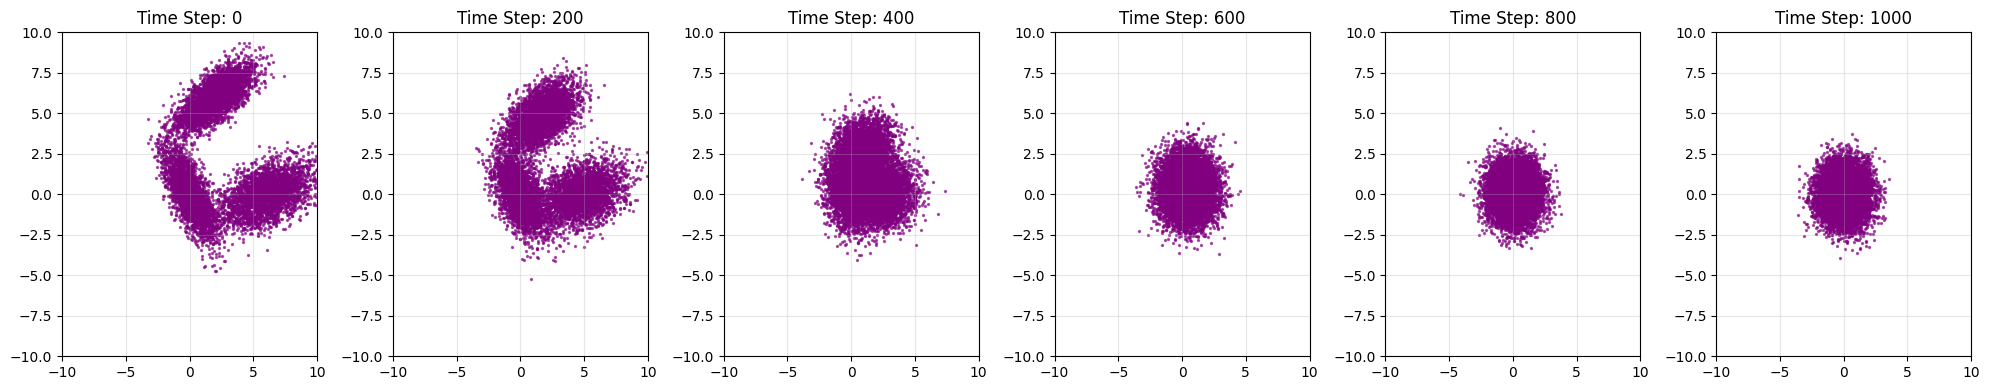

In [8]:
fig, axes = plt.subplots(1, 6, figsize=(20, 4))

limit = 10

for i, t in enumerate(snapshots):
    ax = axes[i]
    data = stored_data[t]

    ax.scatter(data[:, 0], data[:, 1], s=2, alpha=0.6, c='purple')
    ax.set_title(f"Time Step: {t}")

    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **Reversing noise**

**We aim to come up with a closed form analytical solution to reverse the noise that was added in forward process. We start by rewriting $z_t$ with respect to $\alpha_t$ and $x_t$, and then rearranging the original update (from $x_t$ to $x_{t + 1}$) through substituting $z_t$ to reverse the process**

Begin with the update $$x_{t + 1} = \sqrt{1 - \beta_t} x_t + \sqrt{\beta_t}z_t$$
Let $\alpha_t = 1 - \beta_t$. Then, we can rearrange so

$$
x_{t + 1} = \sqrt{\alpha_t} x_t + \sqrt{1 - \alpha_t}z_t \\
\implies
\sqrt{\alpha_t} x_t = x_{t + 1} -  \sqrt{1 - \alpha_t}z_t \\
\implies
\sqrt{\alpha_t} x_{t - 1} = x_{t} -  \sqrt{1 - \alpha_t}z_t \\
\implies
x_{t} -  \sqrt{\alpha_t} x_{t - 1} = \sqrt{1 - \alpha_t}z_t \\
$$

We now aim to find $z_t$ with respect to $x_t$ and $\alpha_t$ to reverse this process.

Since
$$ z_t \sim \mathcal{N} (0, I) \implies
\sqrt{1 - \alpha_t}z_t \sim \mathcal{N} (0, (1 - \alpha_t)I)
$$
The probability of $x_t$ is
$$
\begin{align}
p(x_t) &∝ \exp(\frac{-(\sqrt{1 - \alpha_t}z_t)^2}{2(1 - \alpha_t)})\\
&∝ \exp(\frac{-(1 - \alpha_t) z_t^2}{2(1 - \alpha_t)}) \\
&∝ \exp(\frac{-z_t^2}{2}) \\
\end{align}
$$

Taking the log on both sides we obtain:
$$
logp(x_t) = \frac{-z_t^2}{2}\\
\begin{align}
\implies \nabla_{x_t} logp(x_t) &= -z_t \frac{dz}{dx} \\
&= -z_t \frac{1}{\sqrt{1 - \alpha_t}}\\
\end{align}\\
\implies z_t = - \sqrt{1 - \alpha_t}\nabla_{x_t} logp(x_t)
$$

Since we now know $z_t$ with respect to $\alpha_t$ and $x_t$, we now take our original update process and show how we go from $x_{t}$ to $x_{t-1}$.
$$
\begin{align}
x_{t + 1} &= \sqrt{\alpha_t} x_t + \sqrt{1 - \alpha_t}z_t \\
\implies
\sqrt{\alpha_t} x_t &= x_{t + 1} -  \sqrt{1 - \alpha_t}z_t \\
\implies
x_t &= \frac{1}{\sqrt{\alpha_t}}(x_{t + 1} -  \sqrt{1 - \alpha_t}z_t) \\
\implies
x_{t-1} &= \frac{1}{\sqrt{\alpha_t}}(x_{t} -  \sqrt{1 - \alpha_t}z_t) \\
&= \frac{1}{\sqrt{\alpha_t}}(x_{t} -  \sqrt{1 - \alpha_t}(- \sqrt{1 - \alpha_t}\nabla_{x_t} logp(x_t)) \\
&= \frac{1}{\sqrt{\alpha_t}}(x_{t} +  (1 - \alpha_t) \nabla_{x_t} logp(x_t))
\end{align}
$$

The DDPM paper uses a neural network to estimate the score function. However, since we simulated the data points, we can analytically derive the score function.

Furthermore, like the DDPM paper, we will add some random noise at each time step in the reverse process to ensure that all the noise points do not all converge towards the mean of our generated data. $\sqrt{\beta_t}$ will be chosen scaling factor for the added noise to ensure consistency with the paper.

And thus, our update is as follows:
$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_{t} + (1 - \alpha_t)∇_{x_t}log p_t(x_t)) + \sqrt{\beta_t} z_t
$$
where $z_t \sim \mathcal{N}(0, I)$

### **Score function**

We now break down the score function $∇_{x_t}log p(x_t)$, to find the gradient that leads noisy points back to the original distribution with our current point $x_t$ as the input.

By combining the derivative of logarithms with chain rule,
$$∇log p(x) = \frac{\nabla p(x)}{p(x)}$$

Next, suppose $K$ is the number of clusters in our GMM. Then, $p(x)$, the pdf, is given as follows

$$p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N} (x; \mu_k, Σ_k)$$

where $\pi_k$ is the weight of the k-th cluster.

Taking the gradient,
$$\nabla p(x) = \sum_{k=1}^{K} \pi_k \nabla \mathcal{N} (x; \mu_k, Σ_k)$$

Since $\mathcal{N} (x; \mu_k, Σ_k) \propto \exp(\frac{1}{2}(x - \mu_k)^T Σ_{k}^{-1}(x - \mu_k))$,

$$
\begin{align}
\nabla \mathcal{N} (x; \mu_k, Σ_k) &= \mathcal{N} (x; \mu_k, Σ_k) \times [-Σ_{k}^{-1}(x - \mu_k)]
\end{align}
$$

Thus, putting it all together, we obtain
$$∇log p(x) = \frac{\sum_{k=1}^{K} \pi_k \mathcal{N} (x; \mu_k, Σ_k) \times [-Σ_{k}^{-1}(x - \mu_k)]}{\sum_{k=1}^{K} \pi_k \mathcal{N} (x; \mu_k, Σ_k)}$$

And thus our update fully written out is,
$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_{t} + (1 - \alpha_t)\frac{\sum_{k=1}^{K} \pi_k \mathcal{N} (x; \mu_k, Σ_k) \times [-Σ_{k}^{-1}(x - \mu_k)]}{\sum_{k=1}^{K} \pi_k \mathcal{N} (x; \mu_k, Σ_k)}) + \sqrt{\beta_t} z_t$$

With these derivations, we implement the function to obtain the score

In [9]:
def get_analytical_score(x_t, t_idx):
    alpha_bar = alphas_cumprod[t_idx]

    current_means = np.array([mu * np.sqrt(alpha_bar) for mu in gmm.means_])

    # Sigma_t = alpha_bar * Sigma_0 + (1 - alpha_bar) * I
    current_covs = []
    for cov in gmm.covariances_:
        expanded_cov = (cov * alpha_bar) + ((1 - alpha_bar) * np.eye(2))
        current_covs.append(expanded_cov)

    N = x_t.shape[0]
    K = len(gmm.weights_)
    dim = x_t.shape[1]

    densities = np.zeros((N, K))
    gradients = np.zeros((N, K, dim))

    for k in range(K):
        # p_k(x): n data points, k probability densities for each point
        p_k = multivariate_normal.pdf(x_t, mean=current_means[k], cov=current_covs[k])
        densities[:, k] = gmm.weights_[k] * p_k

        # Gradient of component k: -Sigma_inv * (x - mu)
        inv_cov = np.linalg.inv(current_covs[k])
        diff = x_t - current_means[k]

        # We compute -inv_cov dot diff for each point
        # diff is (N, 2), inv_cov is (2, 2). Result is (N, 2)
        gradients[:, k, :] = -np.dot(diff, inv_cov)

    # Numerator: Sum(pi * p_k * grad_k)
    numerator = np.sum(densities[:, :, np.newaxis] * gradients, axis=1)

    # Denominator: Sum(pi * p_k), densities has pi * p_k
    denominator = np.sum(densities, axis=1)[:, np.newaxis]

    # Safety clip to avoid division by zero
    denominator = np.maximum(denominator, 1e-20)

    return numerator / denominator

**Reverse process of denoising**


We begin by setting the number of datasets we want to see be reveresed and the number of points in each data set

In [10]:
num_instances = 3
points_per_instance = 800
total_samples = num_instances * points_per_instance

In [11]:
x_reverse = np.random.normal(loc=0, scale=1.0, size=(total_samples, 2))
reverse_history = {1000: x_reverse.copy()}


for t in reversed(range(T)):
    score_t = get_analytical_score(x_reverse, t)

    alpha_t = alphas[t]
    beta_t = betas[t]

    # x_{t-1} = 1/sqrt(alpha) * (x_t + (1 - alpha) * Score)
    mean_pred = (1 / np.sqrt(alpha_t)) * (x_reverse + (1 - alpha_t) * score_t)

    # Add noise so points don't simply converge towards mean
    if t > 0:
        z = np.random.normal(size=x_reverse.shape)
        sigma_t = np.sqrt(beta_t)
        x_reverse = mean_pred + (sigma_t * z)
    else:
        x_reverse = mean_pred

    if t in snapshots:
        reverse_history[t] = x_reverse.copy()

**Visualization of the noise removal**

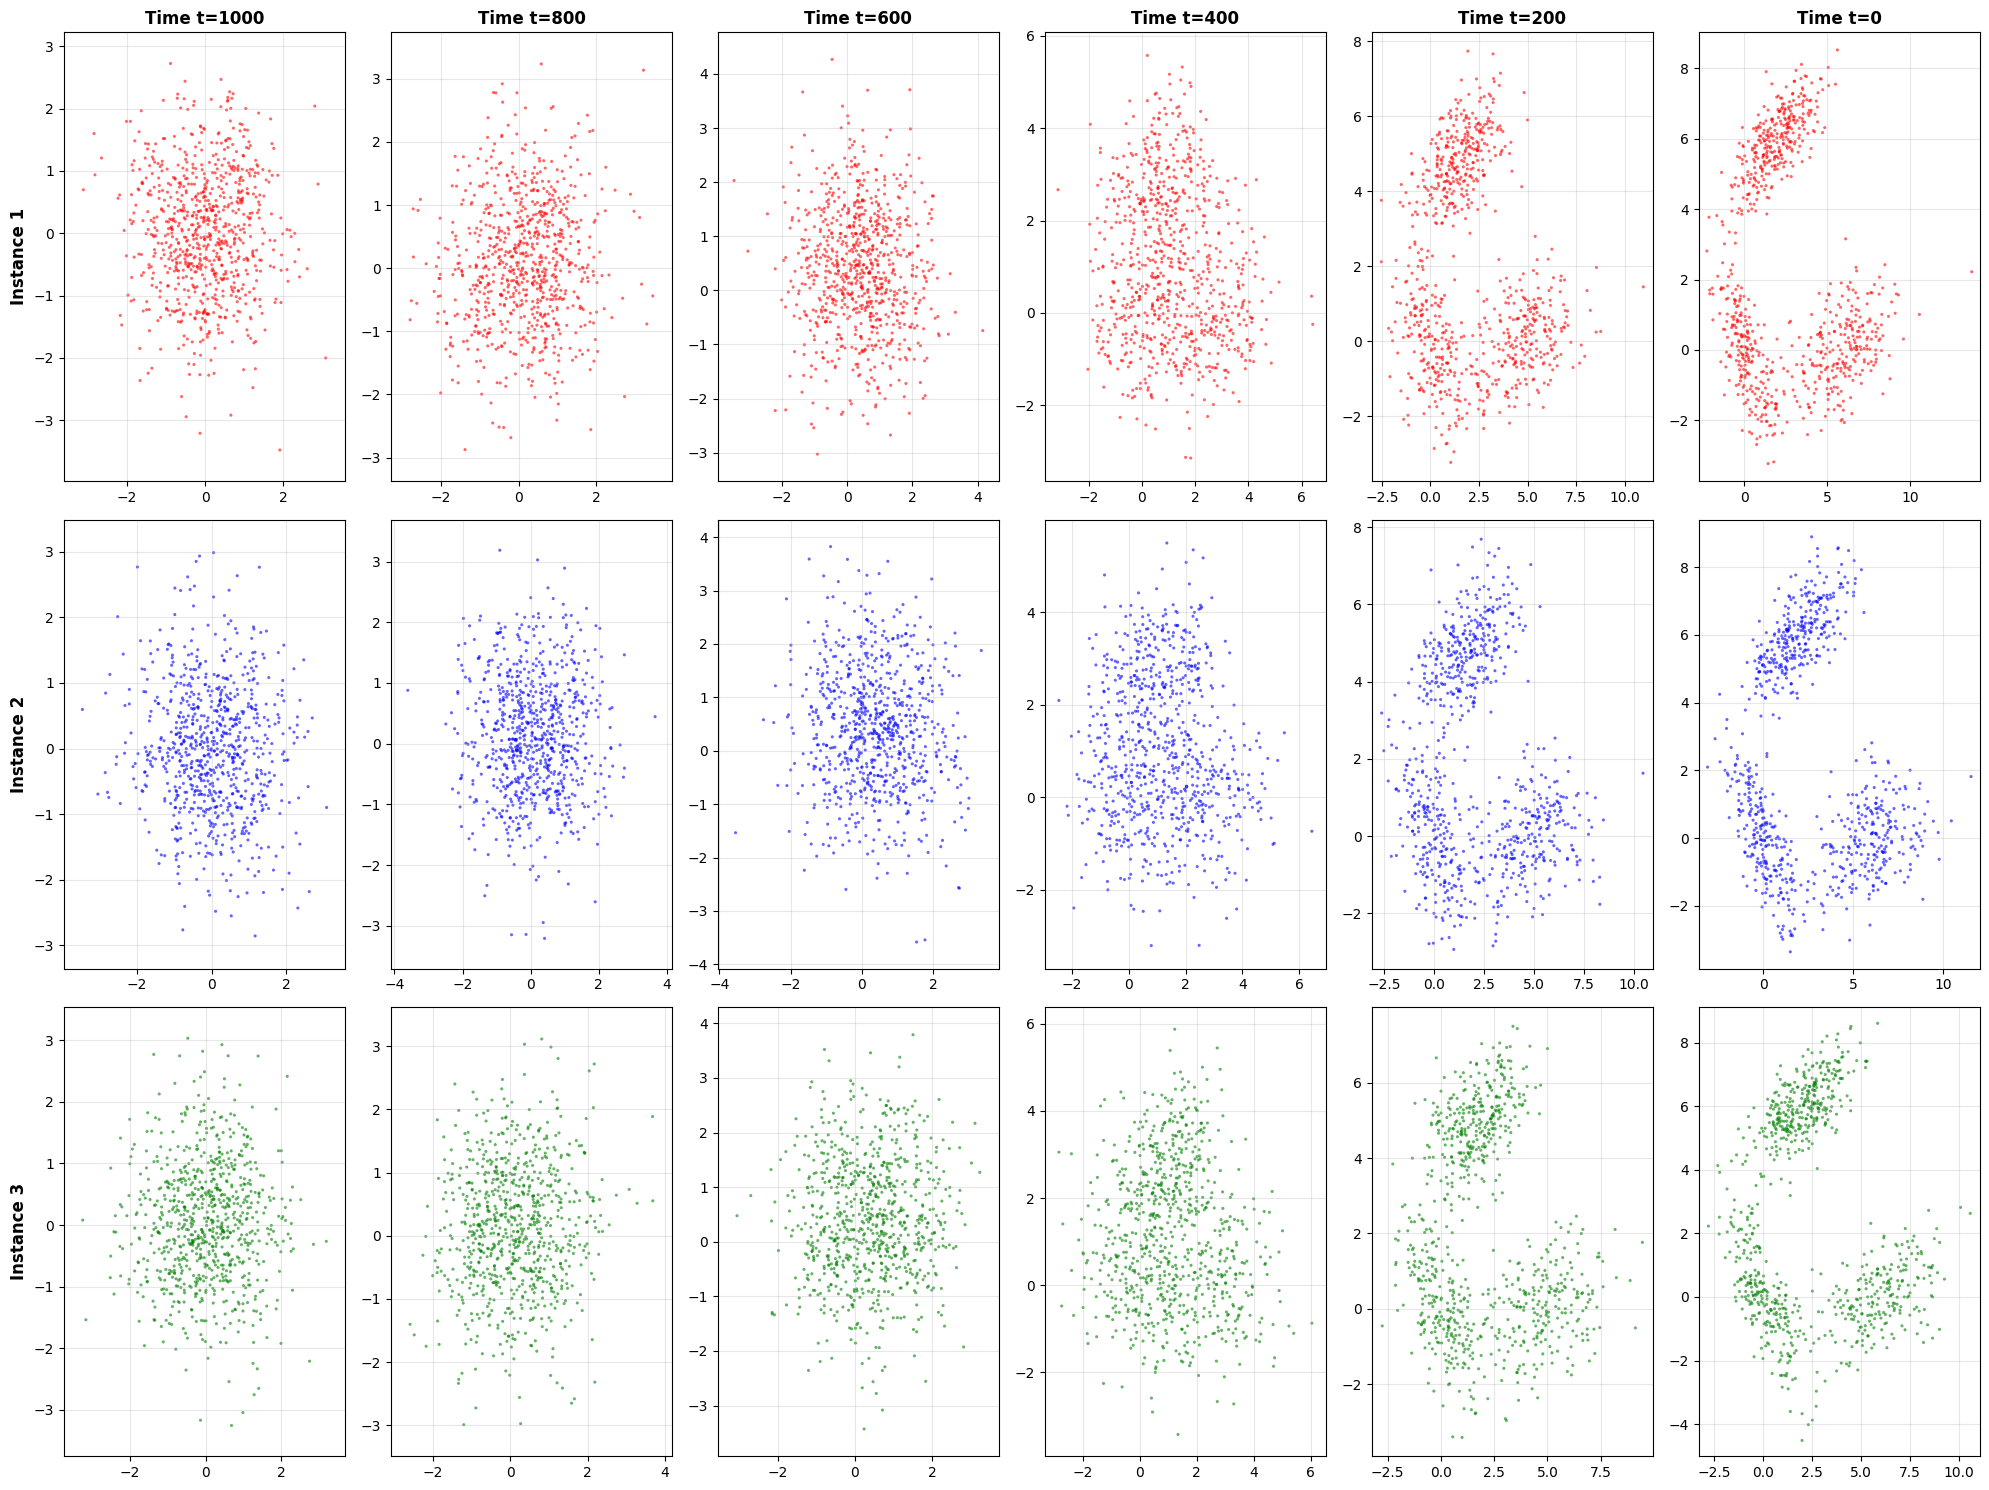

In [12]:
fig, axes = plt.subplots(num_instances, len(snapshots), figsize=(20, 15))
limit = 8

colors = ['red', 'blue', 'green', 'orange', 'purple']

for row_idx in range(num_instances):
    start_idx = row_idx * points_per_instance
    end_idx = (row_idx + 1) * points_per_instance

    for col_idx, t in enumerate(sorted(snapshots, reverse=True)):
        ax = axes[row_idx, col_idx]

        # Extract the specific 500 points for this instance at time t
        all_data_at_t = reverse_history[t]
        instance_data = all_data_at_t[start_idx:end_idx]

        ax.scatter(instance_data[:, 0], instance_data[:, 1],
                   s=5, alpha=0.6, c=colors[row_idx], edgecolors='none')

        if row_idx == 0:
            ax.set_title(f"Time t={t}", fontsize=12, fontweight='bold')

        if col_idx == 0:
            ax.set_ylabel(f"Instance {row_idx + 1}", fontsize=12, fontweight='bold')

        x_min, x_max = instance_data[:, 0].min(), instance_data[:, 0].max()
        y_min, y_max = instance_data[:, 1].min(), instance_data[:, 1].max()
        padding = 0.5

        ax.set_xlim(x_min - padding, x_max + padding)
        ax.set_ylim(y_min - padding, y_max + padding)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## What if we didn't know the underlying distribution of where our data was generated from?

We managed to make a model that can analytically compute the score at each time step allowing us to take noise and bring it back towards the underlying distribution of the data. However, in the case we do not know the distribution, the best we could hope for is that we can use the loss function to guide us back towards the underlying distribution.

When we computed the process for the noise reversal process, we concluded:

$$z_t = - \sqrt{1 - \bar{\alpha_t}}\nabla_{x_t} logp(x_t)$$

and

$$x_{t - 1} = \frac{1}{\sqrt{\alpha_t}}(x_{t} +  (1 - \alpha_t) \nabla_{x_t} logp(x_t))$$

We chose to replace $z_t$ with $ - \sqrt{1 - \alpha_t}\nabla_{x_t} logp(x_t)$ because we could compute $\nabla_{x_t} logp(x_t)$ analytically.

Let us now assume we do not know $p(x)$ and, therefore, we do not know $\nabla_{x_t} logp(x_t)$. Since we do not know $\nabla_{x_t} logp(x_t)$, we can rewrite

$$x_{t - 1} = \frac{1}{\sqrt{\alpha_t}}(x_{t} - \frac{(1 - \alpha_t)} { \sqrt{1 - \bar{\alpha_t} }} z_t)$$

following the fact that $-\frac{z_t}{\sqrt{1 - \bar{\alpha_t}}} =  \nabla_{x_t} logp(x_t)$.

Now define loss function
$$L(\theta) = \mathbb{E}_{t, x_t, \epsilon}[\lVert \epsilon - \epsilon_{\theta}(x_t, t) \rVert^2]$$

With this objective, we are estimating $\epsilon = z_t$. Therefore, we train $\epsilon_{\theta}(x_t, t)$ to learn $\epsilon$ allowing us to rewrite the reverse process as:

$$x_{t - 1} = \frac{1}{\sqrt{\alpha_t}}(x_{t} - \frac{(1 - \alpha_t)} { \sqrt{1 - \bar{\alpha_t} }}\epsilon_{\theta}(x_t, t) )$$

Lastly, we add some noise to ensure all points do not converge towards the mean giving the final update equation as:

$$x_{t - 1} = \frac{1}{\sqrt{\alpha_t}}(x_{t} - \frac{(1 - \alpha_t)} { \sqrt{1 - \bar{\alpha_t} }}\epsilon_{\theta}(x_t, t)) + \sigma_t z$$

### Neural Network to predict noise

A simple neural network is designed to predict the noise which takes in $x_t$ and $t$ as the input.

Time is embedded as sinusoidal positional embeddings so subtle differences are noticed more within the network. After vectorizig time and the data point, their sum is passed in as the input to the hidden layers.

The network has 3 hidden layers and uses SiLu as the activation function.

In [13]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleDiffusionMLP(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        # Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )

        # Input Projection
        self.input_mlp = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )

        # Hidden Layers
        self.mid_layer1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.SiLU())
        self.mid_layer2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.SiLU())
        self.mid_layer3 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.SiLU())

        # Output projection
        self.final_layer = nn.Linear(hidden_dim, 2)

    def forward(self, x, t):
        # x shape: (batch, 2)
        # t shape: (batch)

        # Embed time and reshape
        t_emb = self.time_mlp(t)

        # Embed input
        x_emb = self.input_mlp(x)

        # Combine
        h = x_emb + t_emb

        # Pass through layers with residual connections
        h = h + self.mid_layer1(h)
        h = h + self.mid_layer2(h)
        h = h + self.mid_layer3(h)

        return self.final_layer(h)

We now train the neural network based off of the simulated dataset.

Begin by setting hyperparameters

In [17]:
# Hyperparameters
T = 1000
BATCH_SIZE = 512
LR = 1e-3
EPOCHS = 3000

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# redefining variables for pytorch
betas = torch.linspace(0.0001, 0.02, T).to(DEVICE)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# Data preprocessing for standard normal distribution
tensor_x = torch.Tensor(X_simulated).to(DEVICE)
N_SAMPLES = tensor_x.shape[0]

data_mean = tensor_x.mean(dim=0)
data_std = tensor_x.std(dim=0)
tensor_x = (tensor_x - data_mean) / data_std


model = SimpleDiffusionMLP(hidden_dim=256).to(DEVICE)
model = torch.compile(model, mode='reduce-overhead')

optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

model.train()
optimizer.zero_grad()

print("Starting Training on X_simulated...")

for epoch in range(EPOCHS):
    indices = torch.randperm(N_SAMPLES, device=DEVICE)

    for start_idx in range(0, N_SAMPLES, BATCH_SIZE):
        # Slice the batch directly on GPU
        batch_idx = indices[start_idx : start_idx + BATCH_SIZE]
        batch_x0 = tensor_x[batch_idx]

        current_batch_size = batch_x0.shape[0]

        t = torch.randint(0, T, (current_batch_size,), device=DEVICE)
        epsilon = torch.randn_like(batch_x0)

        sqrt_alpha = sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alpha = sqrt_one_minus_alphas_cumprod[t].view(-1, 1)

        x_t = sqrt_alpha * batch_x0 + sqrt_one_minus_alpha * epsilon

        pred_epsilon = model(x_t, t)
        loss = loss_fn(epsilon, pred_epsilon)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5f}")

Starting Training on X_simulated...
Epoch 0 | Loss: 0.29665
Epoch 100 | Loss: 0.29354
Epoch 200 | Loss: 0.24007
Epoch 300 | Loss: 0.22243
Epoch 400 | Loss: 0.24463
Epoch 500 | Loss: 0.24723
Epoch 600 | Loss: 0.22554
Epoch 700 | Loss: 0.21642
Epoch 800 | Loss: 0.23421
Epoch 900 | Loss: 0.20456
Epoch 1000 | Loss: 0.19629
Epoch 1100 | Loss: 0.20512
Epoch 1200 | Loss: 0.22403
Epoch 1300 | Loss: 0.19549
Epoch 1400 | Loss: 0.20315
Epoch 1500 | Loss: 0.21916
Epoch 1600 | Loss: 0.24427
Epoch 1700 | Loss: 0.25036
Epoch 1800 | Loss: 0.25317
Epoch 1900 | Loss: 0.30159
Epoch 2000 | Loss: 0.19404
Epoch 2100 | Loss: 0.19697
Epoch 2200 | Loss: 0.22398
Epoch 2300 | Loss: 0.27900
Epoch 2400 | Loss: 0.25229
Epoch 2500 | Loss: 0.25066
Epoch 2600 | Loss: 0.21690
Epoch 2700 | Loss: 0.18938
Epoch 2800 | Loss: 0.23274
Epoch 2900 | Loss: 0.20217


Now that we have trained the models, we run the reverse process of denoising

Begin by setting the number of data points to generate for noise

In [19]:
samples = 1000

In [25]:
@torch.no_grad()
def sample_and_return_start(model, n_samples=2000):
    model.eval()

    # Generate pure noise
    x_start = torch.randn(n_samples, 2).to(DEVICE)
    x = x_start.clone()

    for i in reversed(range(T)):
        t = torch.full((n_samples,), i, device=DEVICE, dtype=torch.long)

        predicted_noise = model(x, t)

        alpha = alphas[i]
        alpha_bar = alphas_cumprod[i]
        beta = betas[i]

        if i > 0:
            z = torch.randn_like(x)
        else:
            z = torch.zeros_like(x)

        coeff = (1 - alpha) / torch.sqrt(1 - alpha_bar)
        mean = (1 / torch.sqrt(alpha)) * (x - coeff * predicted_noise)
        sigma = torch.sqrt(beta)

        x = mean + sigma * z

    start_samples = ((x_start * data_std) + data_mean).cpu().numpy()
    final_samples = ((x * data_std) + data_mean).cpu().numpy()

    return start_samples, final_samples

start_data, end_data = sample_and_return_start(model)

/usr/local/lib/python3.12/dist-packages/torch/_inductor/cudagraph_trees.py:2450: UserWarning: Unable to hit fast path of CUDAGraphs because of pending, uninvoked backwards. Consider running with torch.no_grad() or using torch.compiler.cudagraph_mark_step_begin() before each model invocation
  warnings.warn(


Visualize sampling from neural network

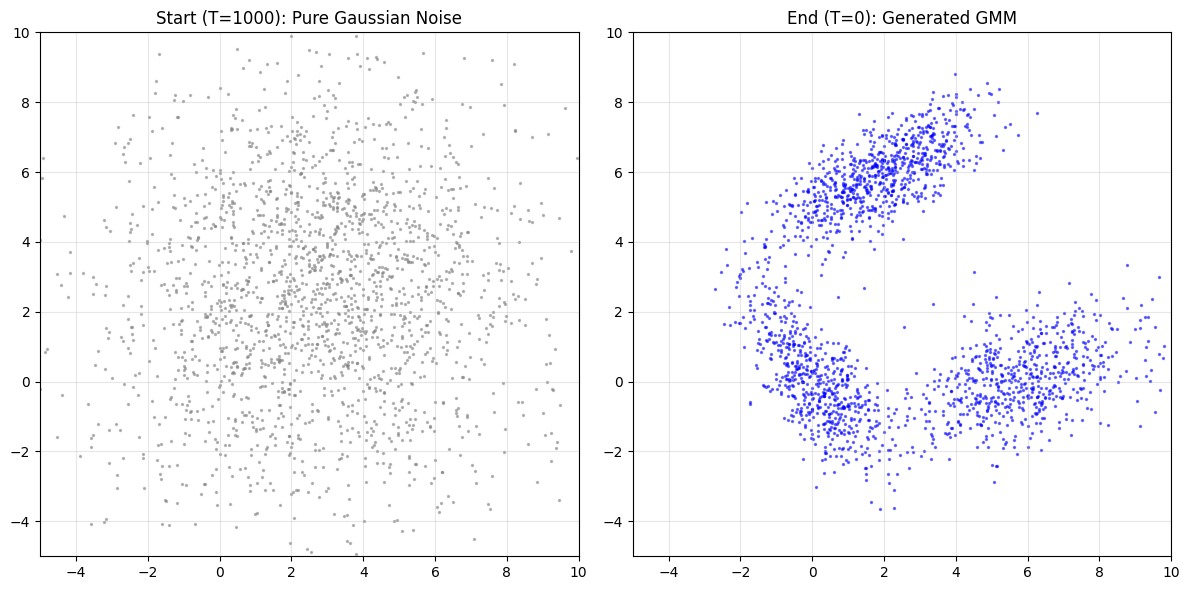

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(start_data[:, 0], start_data[:, 1], s=2, alpha=0.5, color='gray')
plt.title(f"Start (T={T}): Pure Gaussian Noise")
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(end_data[:, 0], end_data[:, 1], s=2, alpha=0.5, color='blue')
plt.title("End (T=0): Generated GMM")
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Testing diffusion model on simulated spiral dataset

Now that we have came up with a neural network to estimate noise, we attempt to use it on a different manifold. We use sklearn's swiss roll and project it onto 2d space.

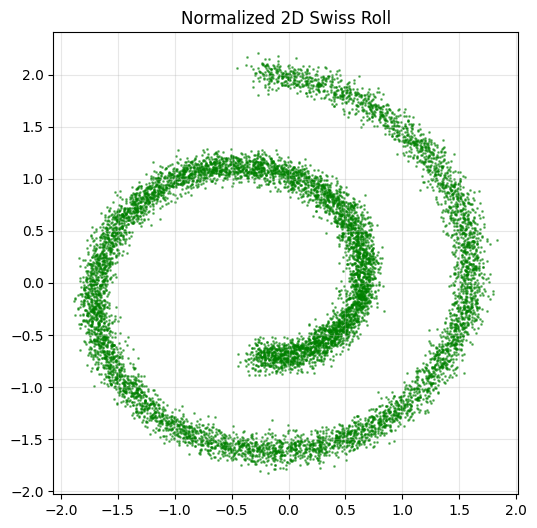

In [30]:
def make_swiss_roll_2d(n_samples=10000, noise=0.1):
    data, _ = sklearn.datasets.make_swiss_roll(n_samples=n_samples, noise=noise)

    # Project
    data_2d = data[:, [0, 2]]

    # normalize
    data_2d = (data_2d - data_2d.mean(axis=0)) / data_2d.std(axis=0)

    return data_2d.astype(np.float32)
X_simulated = make_swiss_roll_2d(n_samples=10000, noise=0.5)

# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(X_simulated[:, 0], X_simulated[:, 1], s=1, alpha=0.5, color='green')
plt.title("Normalized 2D Swiss Roll")
plt.grid(True, alpha=0.3)
plt.show()

We now add noise at each time step like before: $x_{t} = \sqrt{ \bar{\alpha_{t} } } x_0 + \sqrt{1 - \bar{\alpha_t} } z_{t-1}$

In [32]:
T = 250
T = 1000
snapshots = [0, 200, 400, 600, 800, 1000]

betas = np.linspace(0.0001, 0.02, T)
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas)

In [33]:
x_curr = X_simulated.copy()
stored_data = {0: x_curr.copy()}

for t in snapshots:
    if t == 0: continue

    # adjust for 0 index
    t_idx = t - 1

    alpha_bar = alphas_cumprod[t_idx]
    sqrt_alpha_bar = np.sqrt(alpha_bar)
    one_minus_alpha_bar = 1.0 - alpha_bar

    x = sqrt_alpha_bar * x_curr + np.sqrt(one_minus_alpha_bar) * np.random.normal(size=x_curr.shape)
    stored_data[t] = x


Visualize

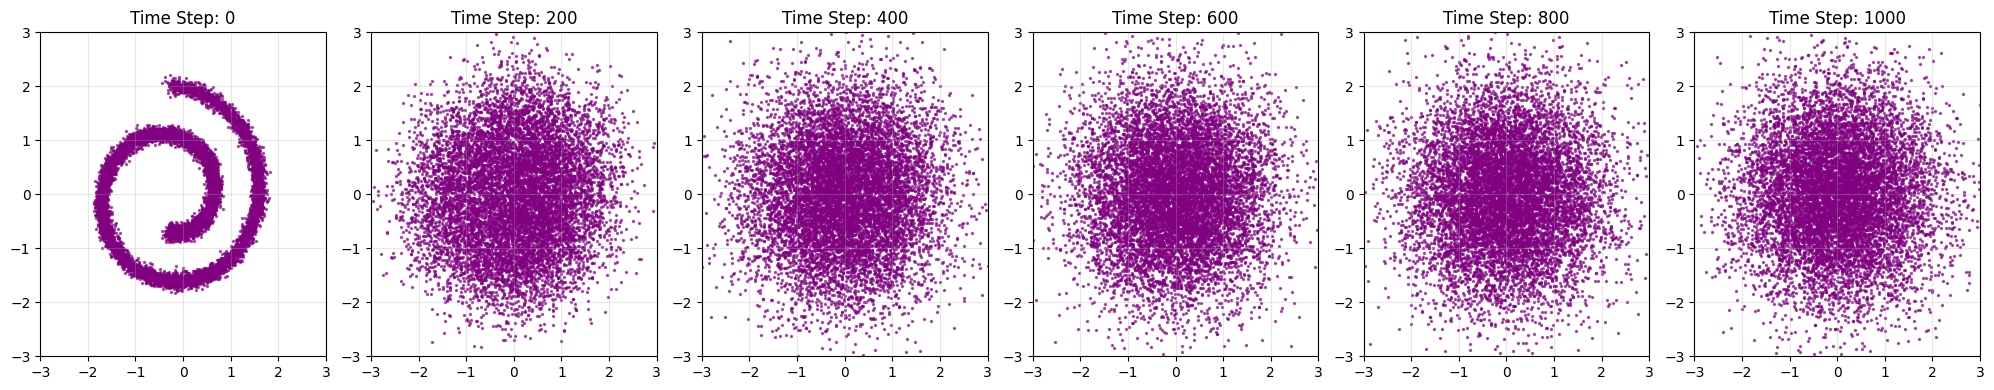

In [35]:
fig, axes = plt.subplots(1, 6, figsize=(20, 4))

limit = 3

for i, t in enumerate(snapshots):
    ax = axes[i]
    data = stored_data[t]

    ax.scatter(data[:, 0], data[:, 1], s=2, alpha=0.6, c='purple')
    ax.set_title(f"Time Step: {t}")

    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Now we train our neural network to estimate noise

In [36]:
# Hyperparameters
T = 1000
BATCH_SIZE = 512
LR = 1e-3
EPOCHS = 3000

In [37]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# redefining variables for pytorch
betas = torch.linspace(0.0001, 0.02, T).to(DEVICE)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# Data preprocessing for standard normal distribution
tensor_x = torch.Tensor(X_simulated).to(DEVICE)
N_SAMPLES = tensor_x.shape[0]


model = SimpleDiffusionMLP(hidden_dim=256).to(DEVICE)
model = torch.compile(model, mode='reduce-overhead')

optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

model.train()
optimizer.zero_grad()

print("Starting Training on X_simulated...")

for epoch in range(EPOCHS):
    indices = torch.randperm(N_SAMPLES, device=DEVICE)

    for start_idx in range(0, N_SAMPLES, BATCH_SIZE):
        # Slice the batch directly on GPU
        batch_idx = indices[start_idx : start_idx + BATCH_SIZE]
        batch_x0 = tensor_x[batch_idx]

        current_batch_size = batch_x0.shape[0]

        t = torch.randint(0, T, (current_batch_size,), device=DEVICE)
        epsilon = torch.randn_like(batch_x0)

        sqrt_alpha = sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alpha = sqrt_one_minus_alphas_cumprod[t].view(-1, 1)

        x_t = sqrt_alpha * batch_x0 + sqrt_one_minus_alpha * epsilon

        pred_epsilon = model(x_t, t)
        loss = loss_fn(epsilon, pred_epsilon)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5f}")

Starting Training on X_simulated...
Epoch 0 | Loss: 0.41104
Epoch 100 | Loss: 0.23334
Epoch 200 | Loss: 0.23913
Epoch 300 | Loss: 0.22200
Epoch 400 | Loss: 0.23330
Epoch 500 | Loss: 0.27187
Epoch 600 | Loss: 0.23694
Epoch 700 | Loss: 0.27563
Epoch 800 | Loss: 0.25629
Epoch 900 | Loss: 0.22390
Epoch 1000 | Loss: 0.23191
Epoch 1100 | Loss: 0.21267
Epoch 1200 | Loss: 0.25134
Epoch 1300 | Loss: 0.18421
Epoch 1400 | Loss: 0.29477
Epoch 1500 | Loss: 0.23285
Epoch 1600 | Loss: 0.23115
Epoch 1700 | Loss: 0.17104
Epoch 1800 | Loss: 0.24226
Epoch 1900 | Loss: 0.22615
Epoch 2000 | Loss: 0.25636
Epoch 2100 | Loss: 0.24127
Epoch 2200 | Loss: 0.25530
Epoch 2300 | Loss: 0.24109
Epoch 2400 | Loss: 0.24274
Epoch 2500 | Loss: 0.22078
Epoch 2600 | Loss: 0.18524
Epoch 2700 | Loss: 0.22010
Epoch 2800 | Loss: 0.22423
Epoch 2900 | Loss: 0.17756


Using our trained neural network for sampling

In [38]:
samples = 1000

In [39]:
start_data, end_data = sample_and_return_start(model, samples)

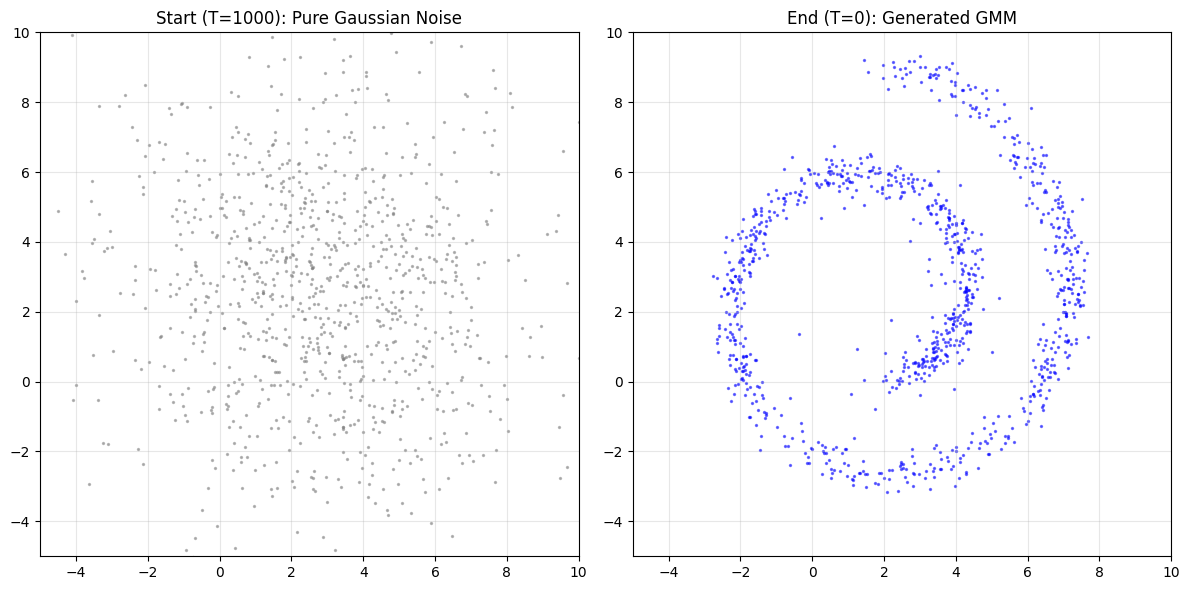

In [40]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(start_data[:, 0], start_data[:, 1], s=2, alpha=0.5, color='gray')
plt.title(f"Start (T={T}): Pure Gaussian Noise")
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(end_data[:, 0], end_data[:, 1], s=2, alpha=0.5, color='blue')
plt.title("End (T=0): Generated GMM")
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()